In [1]:
import torch
import time
import numpy as np

In [274]:
def offset(x, W, W1, rank, device):
    # Create W2 has a random rank=rank matrix
    W2 = torch.randn(W.shape[0], rank, device=device) @ torch.randn(rank, W.shape[1], device=device)
    # Compute ||Wx - W1x||^2 - ||Wx - W2x||^2
    # return torch.norm(W - W1)**2 - torch.norm(W - W2)**2, W2
    return torch.norm(W @ x - W1 @ x)**2 - torch.norm(W @ x - W2 @ x)**2

In [97]:
W = torch.randn(10, 10)
rank = 3
U, S, V = torch.linalg.svd(W)
W1 = U[:, :rank] @ torch.diag(S[:rank]) @ V[:rank, :] # best rank-r approximation 
W2 = U[:, rank:2*rank] @ torch.diag(S[rank:2*rank]) @ V[rank:2*rank] # other rank-r approximation
W3 = U[:, 2*rank:3*rank] @ torch.diag(S[2*rank:3*rank]) @ V[2*rank:3*rank] # other rank-r approximation
x = V[rank:2*rank] # vector in the range of W2 but in the nullspace of W1
print(W1.shape, W2.shape, x.shape)
print("In the nullspace of W*", W1 @ x.T)
print("In the range of W_", W2 @ x.T)
print("In the nullspace of W3", W3 @ x.T)
print("||W-W*||=", torch.norm(W - W1)**2, "     ||W-W_||=",torch.norm(W - W2)**2, "     ||W-W_||=",torch.norm(W - W3)**2)
print("||(W-W*)x||=", torch.norm((W - W1) @ x.T)**2, "      ||(W-W_)x||=", torch.norm((W - W2) @ x.T)**2, "      ||(W-W_)x||=", torch.norm((W - W3) @ x.T)**2)

torch.Size([10, 10]) torch.Size([10, 10]) torch.Size([3, 10])
In the nullspace of W* tensor([[ 3.7498e-07, -6.0669e-07,  3.3513e-09],
        [ 3.4697e-07, -3.7059e-07, -1.9881e-07],
        [-1.3144e-07,  3.9712e-07, -1.6504e-07],
        [ 7.1802e-08, -1.5980e-07,  6.1440e-08],
        [ 3.0088e-07, -2.4848e-07, -2.2888e-07],
        [-3.9783e-07,  3.8467e-07,  1.6893e-07],
        [ 3.9169e-09,  5.0930e-08, -1.8383e-08],
        [-4.6586e-07,  4.9895e-07,  1.5906e-07],
        [ 2.1495e-07, -5.4598e-07, -6.4650e-09],
        [ 2.2278e-07, -1.5553e-08, -3.2197e-07]])
In the range of W_ tensor([[-1.1786,  1.0818,  0.7183],
        [ 1.8274,  1.0159, -1.0983],
        [ 1.2415,  0.4375,  0.7022],
        [ 1.2174, -0.2757,  0.1348],
        [-0.0927, -1.3129,  0.4061],
        [ 0.0567, -0.0392, -1.3799],
        [ 1.7244,  0.1175,  0.7255],
        [ 0.2578, -1.1235,  0.4559],
        [ 0.9079, -1.9432, -0.2779],
        [-1.3316, -0.7078, -0.6139]])
In the nullspace of W3 tensor([[ 5

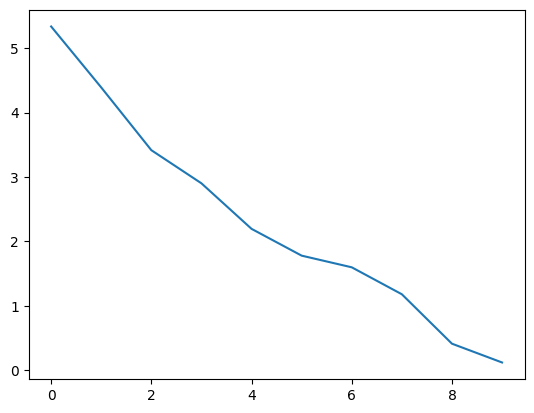

In [282]:
device = "cpu"

W = torch.randn(10, 10).to(device)
U, S, V = torch.linalg.svd(W)
U = U.to(device)
S = S.to(device)
V = V.to(device)

import matplotlib.pyplot as plt
plt.plot(S.cpu().numpy())

In [283]:
means = {}

for rank in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    W1 = U[:, :rank] @ torch.diag(S[:rank]) @ V[:rank, :] # best rank-r approximation
    for im_comp in range(rank+1):
        for ker_comp in range(min(10-rank, 10)):
            if ker_comp + im_comp >= 10:
                continue
            it = 0
            mean = []
            for i in range(50000):
                # x = torch.randn(W.shape[1])

                # Take x with n_comp components in the range of W1 to create a vector of shape (10,)
                x1 = torch.mm(V[:im_comp, :].T, torch.randn(im_comp, 1, device=device))
                x2 = torch.mm(V[rank:rank+ker_comp, :].T, torch.randn(ker_comp, 1, device=device))
                x = x1 + x2

                it += 1
                o = offset(x, W, W1, rank, device)
                if o > 0:
                    mean.append(it)
                    it = 0
            mean.append(it)
            if len(mean) > 0:
                print("Rank:", rank, "im_comp:", im_comp, "ker_comp:", ker_comp, "Mean:", np.mean(mean))
                means[(rank, im_comp, ker_comp)] = np.mean(mean)
            else:
                print("Rank:", rank, "im_comp:", im_comp, "ker_comp:", ker_comp, "Mean: -1")
                means[(rank, im_comp, ker_comp)] = -1

Rank: 1 im_comp: 0 ker_comp: 0 Mean: -1
Rank: 1 im_comp: 0 ker_comp: 1 Mean: 4.0096230954290295
Rank: 1 im_comp: 0 ker_comp: 2 Mean: 4.419731258840169
Rank: 1 im_comp: 0 ker_comp: 3 Mean: 4.74063537221432
Rank: 1 im_comp: 0 ker_comp: 4 Mean: 4.9999
Rank: 1 im_comp: 0 ker_comp: 5 Mean: 5.404128837008215
Rank: 1 im_comp: 0 ker_comp: 6 Mean: 5.605673281758045
Rank: 1 im_comp: 0 ker_comp: 7 Mean: 6.016853256289876
Rank: 1 im_comp: 0 ker_comp: 8 Mean: 6.240544251653976
Rank: 1 im_comp: 1 ker_comp: 0 Mean: -1
Rank: 1 im_comp: 1 ker_comp: 1 Mean: 25.86601138127263
Rank: 1 im_comp: 1 ker_comp: 2 Mean: 19.25664739884393
Rank: 1 im_comp: 1 ker_comp: 3 Mean: 18.286027798098026
Rank: 1 im_comp: 1 ker_comp: 4 Mean: 18.054532322137955
Rank: 1 im_comp: 1 ker_comp: 5 Mean: 17.51927119831815
Rank: 1 im_comp: 1 ker_comp: 6 Mean: 18.005045045045044
Rank: 1 im_comp: 1 ker_comp: 7 Mean: 18.603949329359164
Rank: 1 im_comp: 1 ker_comp: 8 Mean: 19.58996471971776
Rank: 2 im_comp: 0 ker_comp: 0 Mean: -1
Rank: 2

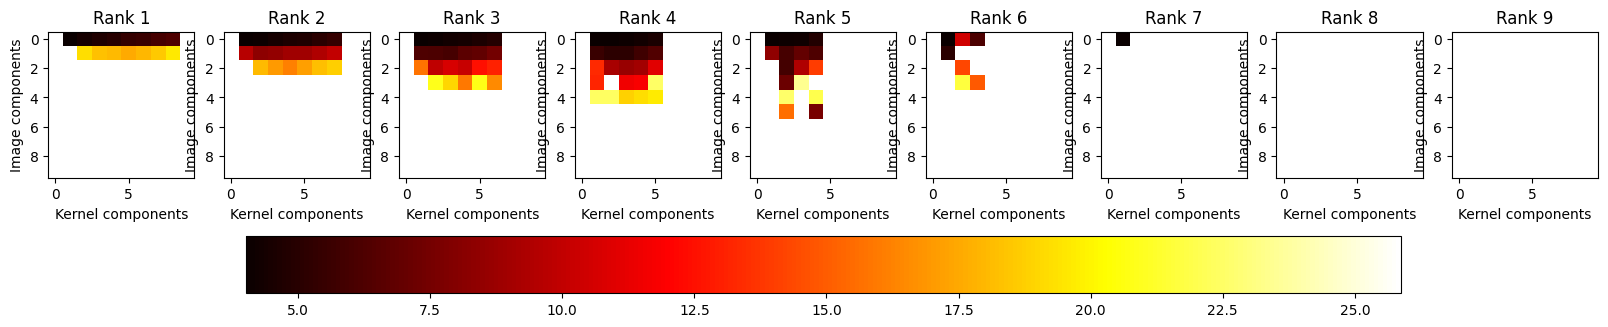

In [284]:
import matplotlib.pyplot as plt

img_tensor = np.ones((9, 10, 10)) * np.nan
for (rank, im_comp, ker_comp), mean in means.items():
    img_tensor[rank-1, im_comp, ker_comp] = mean if mean != -1 else np.nan

fig, ax = plt.subplots(1, 9, figsize=(20, 5))
for i in range(9):
    ax[i].imshow(img_tensor[i], cmap='hot', interpolation='nearest')
    ax[i].set_title(f"Rank {i+1}")
    ax[i].set_ylabel("Image components")
    ax[i].set_xlabel("Kernel components")

# Add a colorbar
fig.colorbar(ax[0].imshow(img_tensor[0], cmap='hot', interpolation='nearest'), ax=ax, orientation='horizontal')
# plt.suptitle("Low-rank approximation is minimizer for generalized Eckart-Young theorem on matrix 10x10")
plt.show()

In [15]:
n = 10
r = 3

def sample(n, r):
    alpha = torch.randn(n) ** 2
    sigma = torch.randn(n)
    theta = torch.randn(r)
    # Make the sigma and theta decreasing
    sigma = torch.sort(sigma, descending=True).values
    theta = torch.sort(theta, descending=True).values
    # Random permutation if [1, ..., n]
    permute = torch.randperm(n)

    # Compute sum alpha_i^2 sigma_i^2  + alpha_(permute_i)^2 theta_i^2
    A = torch.sum(alpha[:r] * (sigma[:r] ** 2)) + torch.sum(alpha[permute[:r]] * (theta ** 2))

    # Compute 2 * sum alpha_i^2 theta_i sigma_(permute_i)
    B = 2 * torch.sum(alpha[:r] * theta * sigma[permute[:r]])

    return A >= B

In [16]:
def experience(n, r, n_samples):
    # Compute the probability of the event
    prob = 0
    for i in range(n_samples):
        prob += sample(n, r)
    return prob / n_samples

In [56]:
import torch

def sample(n, r, n_samples, device='cpu', law='normal'):
    # Generate multiple samples at once for better performance on the GPU
    if law == 'normal':
        alpha = (torch.randn(n_samples, n, device=device) ** 2)  # Move to the GPU
        sigma = torch.randn(n_samples, n, device=device)
        theta = torch.randn(n_samples, r, device=device)
    elif law == 'uniform':
        alpha = (torch.rand(n_samples, n, device=device) ** 2)
        sigma = torch.rand(n_samples, n, device=device)
        theta = torch.rand(n_samples, r, device=device)
    
    # Sort sigma and theta in descending order
    sigma, _ = torch.sort(sigma, descending=True, dim=1)  # Sort along the last dimension
    theta, _ = torch.sort(theta, descending=True, dim=1)
    
    # Generate random permutations for each sample on the GPU
    permute = torch.stack([torch.randperm(n, device=device) for _ in range(n_samples)])  # GPU-based permutation
    
    # Compute sum alpha_i^2 sigma_i^2  + alpha_(permute_i)^2 theta_i^2
    A = torch.sum(alpha[:, :r] * (sigma[:, :r] ** 2), dim=1) + torch.sum(alpha.gather(1, permute[:, :r]) * (theta ** 2), dim=1)
    
    # Compute 2 * sum alpha_i^2 theta_i sigma_(permute_i)
    B = 2 * torch.sum(alpha[:, :r] * theta * sigma.gather(1, permute[:, :r]), dim=1)
    
    return A >= B

def experience(n, r, n_samples, device='cpu', law='normal'):
    # Move computation to the GPU
    prob = torch.mean(sample(n, r, n_samples, device=device, law=law).float())
    return prob


In [44]:
experience(256, 40, 100000, device='cpu')

tensor(0.9999)

In [48]:
# experience(10, 10, 10000)

import matplotlib.pyplot as plt

n_samples = 50000
n = 256
rs = np.linspace(1, n, n)
probs = [experience(n, int(r), n_samples, device="cpu") for r in rs]

In [57]:
probs_unif = [experience(n, int(r), n_samples, device="cpu", law="uniform") for r in rs]

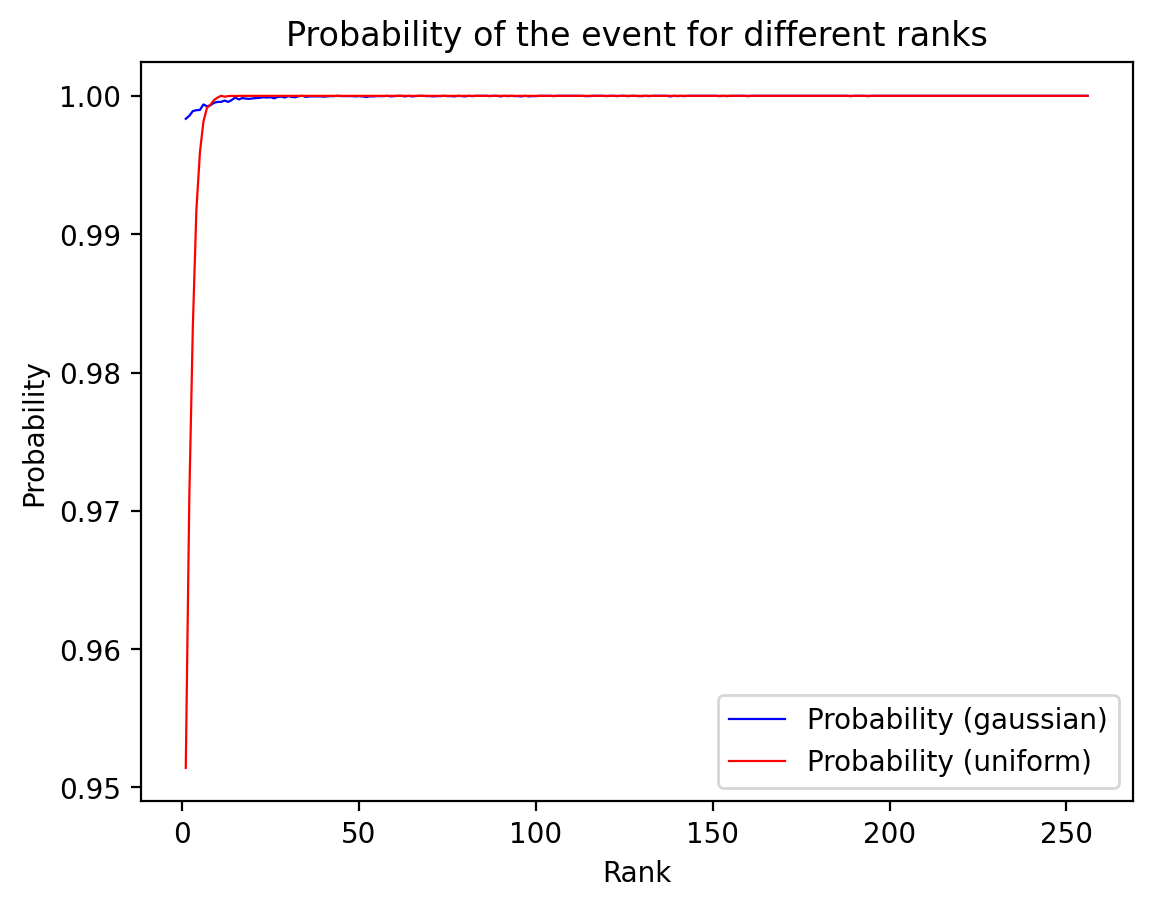

In [58]:
plt.rcParams["figure.dpi"] = 200

plt.xlabel("Rank")
plt.ylabel("Probability")
plt.title("Probability of the event for different ranks")
plt.plot(rs, probs, label="Probability (gaussian)", linestyle='-', color='b', linewidth=0.8)
plt.plot(rs, probs_unif, label="Probability (uniform)", linestyle='-', color='r', linewidth=0.8)
plt.legend()

In [59]:
probs_unif

[tensor(0.9514),
 tensor(0.9709),
 tensor(0.9834),
 tensor(0.9917),
 tensor(0.9959),
 tensor(0.9981),
 tensor(0.9991),
 tensor(0.9994),
 tensor(0.9997),
 tensor(0.9999),
 tensor(1.),
 tensor(0.9999),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv  # kv is the modified Bessel function K_nu
from scipy.stats import expon  # We'll use the exponential distribution as the proposal
# Import chi2 distribution from scipy.stats
from scipy.stats import chi2
# Uniform distribution
from scipy.stats import uniform

from functools import partial

# Define the target distribution f(z) = (1 / (pi * sqrt(z))) * K_0(sqrt(z))
def target_density(z):
    return (1 / (np.pi * np.sqrt(z))) * kv(0, np.sqrt(z))

def chi2_density(z):
    return chi2.pdf(z, 1)

def cosec_density(z):
    # 1/2 * csc^{-1}(sqrt(z))
    return 1 / 2 * np.arcsin(1/np.sqrt(np.where(z >= 1, z, 1)))

def unif_squared_density(z):
    return 1/(2*np.sqrt(np.where(0 <= z <= 1, z, 0)))

# Rejection sampling to generate samples from the distribution
def rejection_sampling(n_samples, proposal_scale=1.0, target_density=target_density):
    samples = []
    count = 0
    # We use an exponential distribution as the proposal distribution
    proposal = expon(scale=proposal_scale)
    
    # We need to determine a good constant c for rejection sampling
    # Here we estimate it heuristically by taking the maximum of target_density/proposal
    c = 1.2  # Adjust this constant based on experimentation
    
    while len(samples) < n_samples:
        z_proposed = proposal.rvs()
        u = np.random.uniform(0, 1)
        if u < target_density(z_proposed) / (c * proposal.pdf(z_proposed)):
            samples.append(z_proposed)
        count += 1
    
    print(f"Acceptance ratio: {len(samples) / count}")
    return np.array(samples)

# Generate samples
n_samples = 1_000
samples_X = rejection_sampling(n_samples, target_density=partial(uniform.pdf, loc=-1, scale=2))
samples_Y = rejection_sampling(n_samples, target_density=partial(uniform.pdf, loc=-1, scale=2))
# samples_Y = rejection_sampling(n_samples, target_density=target_density)

samples_A = rejection_sampling(n_samples, target_density=unif_squared_density)
samples_B = rejection_sampling(n_samples, target_density=unif_squared_density)
# samples_C = rejection_sampling(n_samples, target_density=chi2_density)
# samples_D = rejection_sampling(n_samples, target_density=chi2_density)

# Sum of two independent random variables
samples_Z = samples_A + samples_B
samples_W = samples_X**2 + samples_Y**2

# samples_W = samples_A * samples_B# + samples_C * samples_D

# Plot the histogram of the sum and compare it with the sinh law
z_vals = np.linspace(0, np.max(samples_Z), 1000)
# sinh_pdf = np.sinh(z_vals) / np.trapz(np.sinh(z_vals), z_vals)  # Normalize sinh to match as a PDF


Acceptance ratio: 0.4056795131845842
Acceptance ratio: 0.4035512510088781
Acceptance ratio: 0.9960159362549801
Acceptance ratio: 0.9930486593843099


/tmp/ipykernel_3620666/3489353332.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(2*np.sqrt(np.where(0 <= z <= 1, z, 0)))


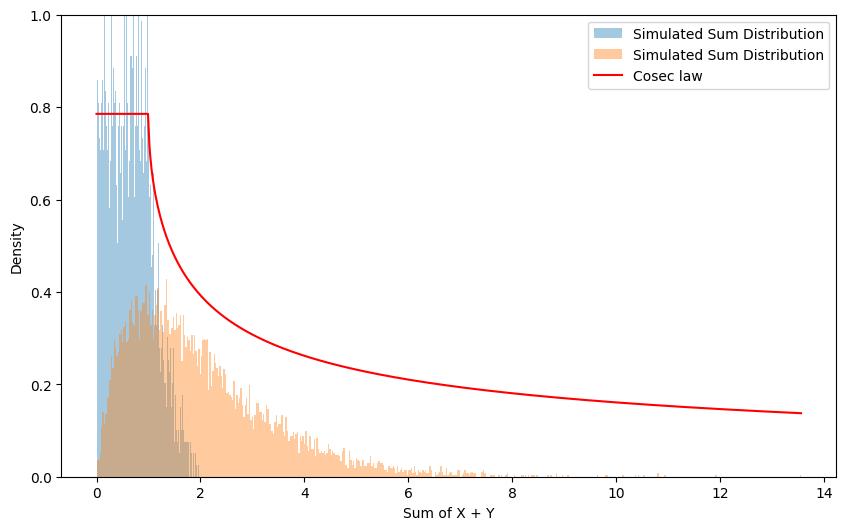

In [54]:
plt.figure(figsize=(10, 6))
plt.hist(samples_W, bins=500, density=True, alpha=0.4, label="Simulated Sum Distribution")
plt.hist(samples_Z, bins=500, density=True, alpha=0.4, label="Simulated Sum Distribution")
# plt.hist(samples_W, bins=500, density=True, alpha=0.4, label="Simulated Sum Distribution", color='red')
plt.plot(np.linspace(0, np.max(samples_Z), 1000), cosec_density(z_vals), label="Cosec law", color='red')
plt.xlabel("Sum of X + Y")
plt.ylabel("Density")
plt.ylim(0, 1.0)
# plt.xlim(0, 20)
plt.legend()
plt.show()

In [18]:
def draw(n_samples, n, r):
    # Draw r random integers from {1, ..., n}
    # Compute how many are in {1, ..., r}
    return torch.sum(torch.randint(1, n+1, (n_samples, r)) <= r) / n_samples

# Create image N x N, where the pixel (i, j) is draw(100000, i, j) for i >= j
N = 64
n_samples = 10000
img = torch.zeros(N, N)
for i in range(N):
    for j in range(i+1):
        img[i, j] = draw(n_samples, i+1, j+1)

In [23]:
img2 = torch.zeros(N, N)
for i in range(N):
    for j in range(i+1):
        img2[i, j] = (j+1)**2 / (i+1)

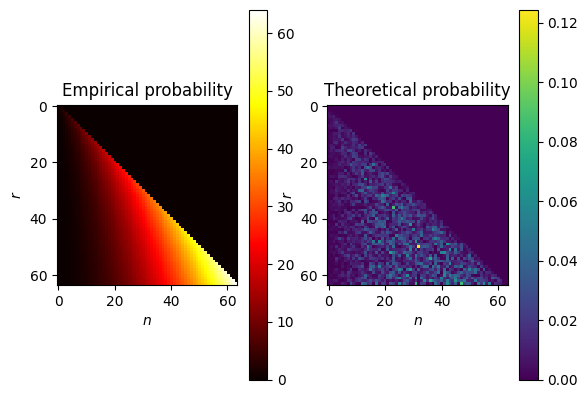

In [36]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='hot', interpolation='nearest')
plt.xlabel("$n$")
plt.ylabel("$r$")
plt.title("Empirical probability")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(torch.abs(img-img2), cmap='viridis', interpolation='nearest')
plt.xlabel("$n$")
plt.ylabel("$r$")
plt.title("Theoretical probability")
plt.colorbar()
plt.show()

In [100]:
import numpy as np
from scipy.special import kv

def density1(x):
    return 1 / (np.pi * np.sqrt(x)) * kv(0, np.sqrt(x))

C = np.sqrt(2) * np.pi
def density2(x):
    return 1 / (C * np.sqrt(x)) * kv(0, np.sqrt(x/2))


In [101]:
# Import from scipy a way to create a continuous random variable from a probability density function
from scipy.stats import rv_continuous


class k1(rv_continuous):
    def _pdf(self, x):
        return kv(0, np.sqrt(x)) / (np.pi * np.sqrt(x))


class k2(rv_continuous):
    def _pdf(self, x):
        return kv(0, np.sqrt(x) / np.sqrt(2)) / (C * np.sqrt(x))
    
K1 = k1(a=0, b=np.inf, name='k1')
K2 = k2(a=0, b=10, name='k2')

In [102]:
kv(0, np.sqrt(1e2000) / np.sqrt(2))

0.0

In [108]:
samples = K1.rvs(size=1000)

In [110]:
mean_k1 = np.mean(samples)
std_k1 = np.std(samples)

mean_k1, std_k1

(0.9986718540687514, 2.933840060437928)

In [104]:
np.mean(K2.rvs(size=1000))

1.355044205002727

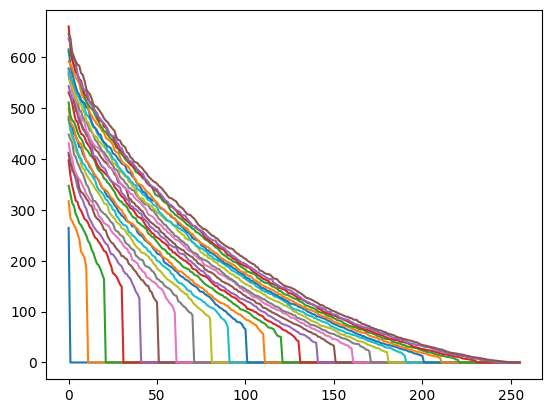

In [6]:
# Create random rank r matrix
def random_rank_r(n, r):
    U = torch.randn(n, r)
    V = torch.randn(r, n)
    return U @ V

for i in range(1, 257, 10):
    _, S, _ = torch.svd(random_rank_r(256, i))
    plt.plot(S.cpu().numpy(), label=f"Rank {i}")

In [128]:
n_samples = 100000
n = 32
rank = 20
sv = [[] for _ in range(rank)]
for i in range(n_samples):
    _, S, _ = torch.svd(random_rank_r(n, rank))
    for j in range(rank):
        sv[j].append(S[j].item())

In [156]:
n_samples = 100000
n2 = 64
rank2 = 20
sv2 = [[] for _ in range(rank2)]
for i in range(n_samples):
    _, S, _ = torch.svd(random_rank_r(n2, rank2))
    for j in range(rank2):
        sv2[j].append(S[j].item())

In [7]:
n_samples = 10000
n4 = 512
rank4 = 20
sv4 = [[] for _ in range(rank4)]
for i in range(n_samples):
    if i % 100 == 0: print(i)
    _, S, _ = torch.svd(random_rank_r(n4, rank4))
    for j in range(rank4):
        sv4[j].append(S[j].item())

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [11]:
n_samples = 100_000
n5 = 20
rank5 = 20
sv5 = [[] for _ in range(rank5)]
for i in range(n_samples):
    _, S, _ = torch.svd(random_rank_r(n5, rank5))
    for j in range(rank5):
        sv5[j].append(S[j].item())

In [285]:
n_samples = 100000
n3 = 32
rank3 = 20

sv3_1 = [[] for _ in range(rank2)]
sv3_2 = [[] for _ in range(rank2)]
for i in range(n_samples):
    _, S1, _ = torch.svd(torch.randn(rank3, n3))
    _, S2, _ = torch.svd(torch.randn(rank3, n2))
    for j in range(rank3):
        sv3_1[j].append(S1[j].item())
        sv3_2[j].append(S2[j].item())

# A = np.zeros_like(m1, dtype=float)
# for i in range(len(S)):
#     A += S[i] * np.outer(U[:, i], V[i, :])
# print("Frobenius Norm:", np.linalg.norm(m1 - A))

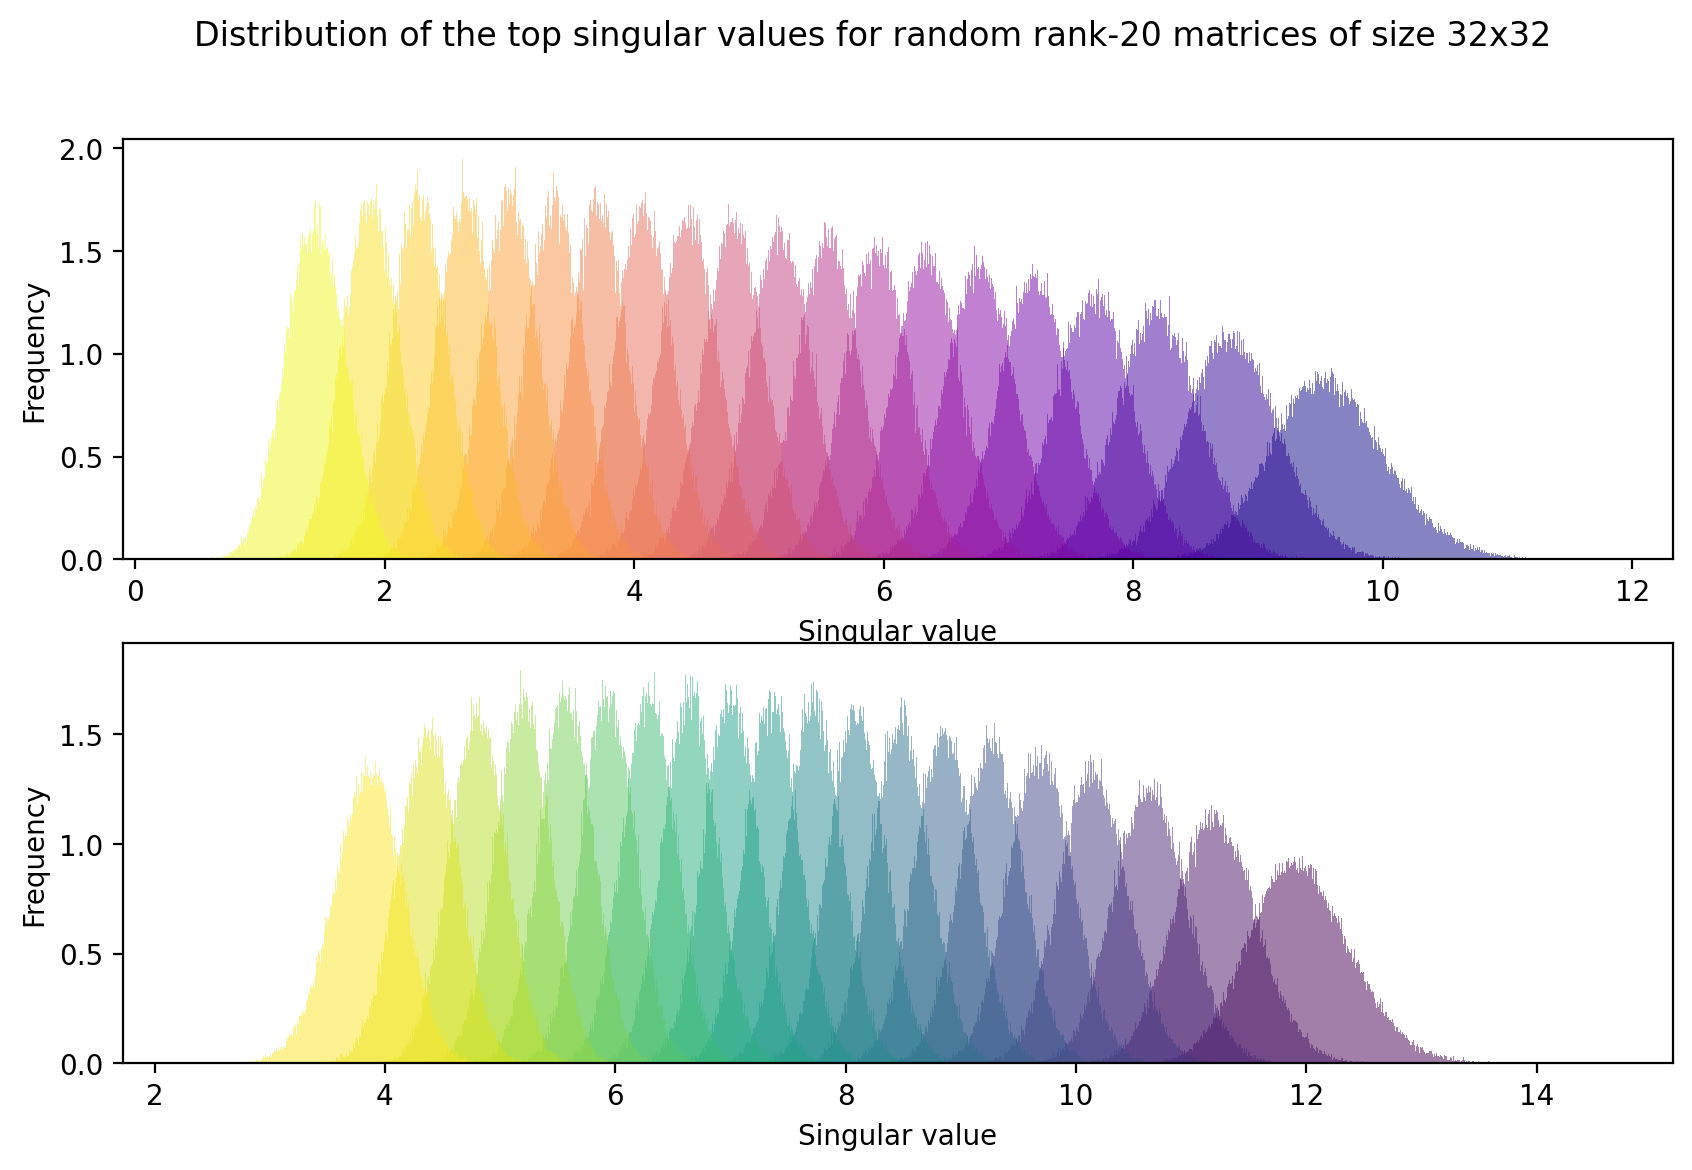

In [286]:
k = rank3
palette = plt.get_cmap('plasma', k)
palette2 = plt.get_cmap('viridis', k)

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
for i in range(k):
    s1 = f"\sigma_{{{i+1}}}"
    plt.hist(sv3_1[i], bins=500, alpha=0.5, density=True, color=palette(i), label=r"$" + s1 + r"$")
# plt.legend(fontsize=7)
plt.xlabel("Singular value")
plt.ylabel("Frequency")

plt.subplot(2, 1, 2)
for i in range(k):
    s1 = f"\sigma_{{{i+1}}}"
    plt.hist(sv3_2[i], bins=500, alpha=0.5, density=True, color=palette2(i), label=r"$" + s1 + r"$")
# plt.legend(fontsize=7)
plt.xlabel("Singular value")
plt.ylabel("Frequency")
plt.suptitle(f"Distribution of the top singular values for random rank-{rank} matrices of size {n}x{n}")
plt.show()


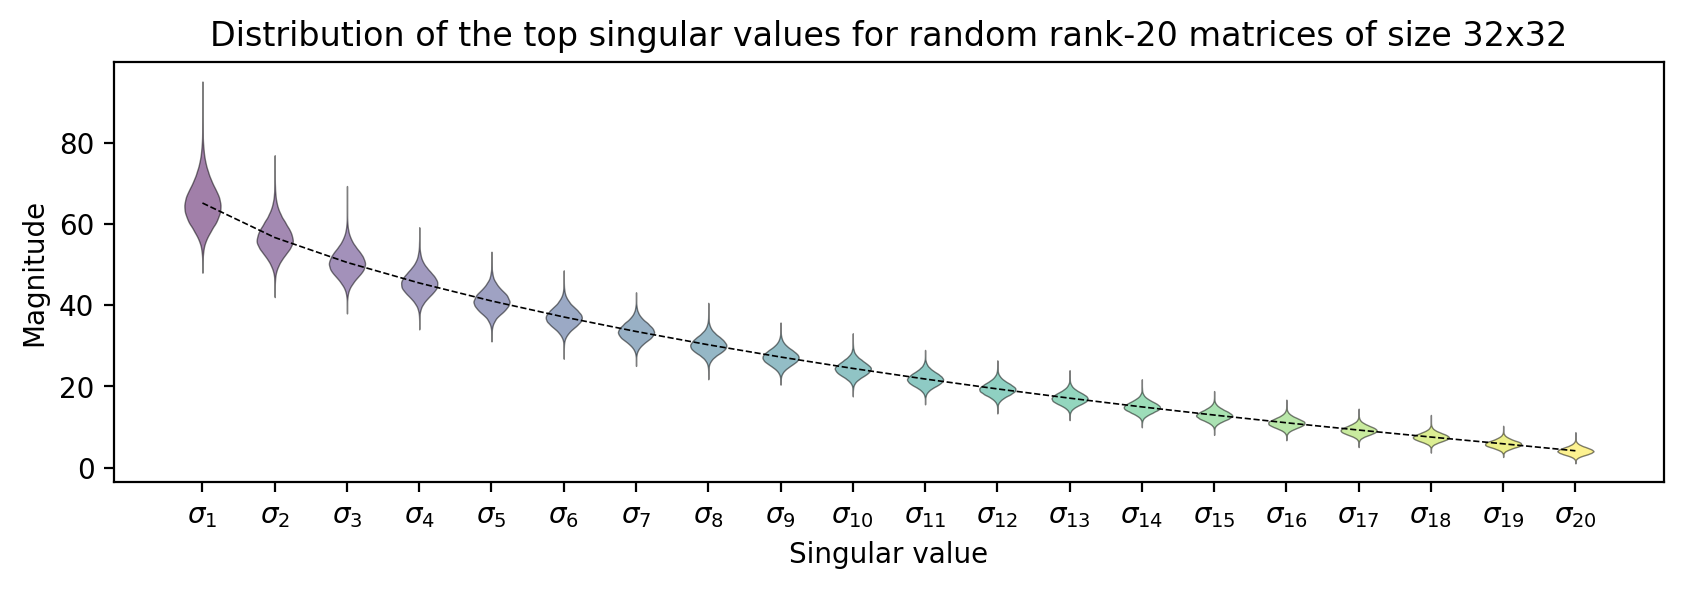

In [329]:
k = rank3
palette = plt.get_cmap('plasma', k)
palette2 = plt.get_cmap('viridis', k)

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)

# Plot errorbar plot
# vp = plt.violinplot(sv3_1, showmeans=False, showextrema=False)
vp2 = plt.violinplot(sv, showmeans=False, showextrema=False)
plt.plot(np.arange(1, k+1), [np.mean(sv[i]) for i in range(k)], color='black', label="Mean", linestyle='--', linewidth=0.6)

# Customize the colors
for i in range(k):
    # vp['bodies'][i].set_facecolor(palette(i))
    # vp['bodies'][i].set_edgecolor('black')
    # vp['bodies'][i].set_edgecolor('black')
    # vp['bodies'][i].set_linewidth(0.5)
    # vp['bodies'][i].set_alpha(0.5)
    
    vp2['bodies'][i].set_facecolor(palette2(i))
    vp2['bodies'][i].set_edgecolor('black')
    vp2['bodies'][i].set_edgecolor('black')
    vp2['bodies'][i].set_linewidth(0.5)
    vp2['bodies'][i].set_alpha(0.5)

# Set xticks to be integers
plt.xticks(np.arange(1, k+1), [f"$\sigma_{{{i+1}}}$" for i in range(k)])
plt.xlabel("Singular value")
plt.ylabel("Magnitude")
plt.title("Distribution of the top singular values for random rank-20 matrices of size 32x32")
plt.savefig("violin_singular_values_20_32x32.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()

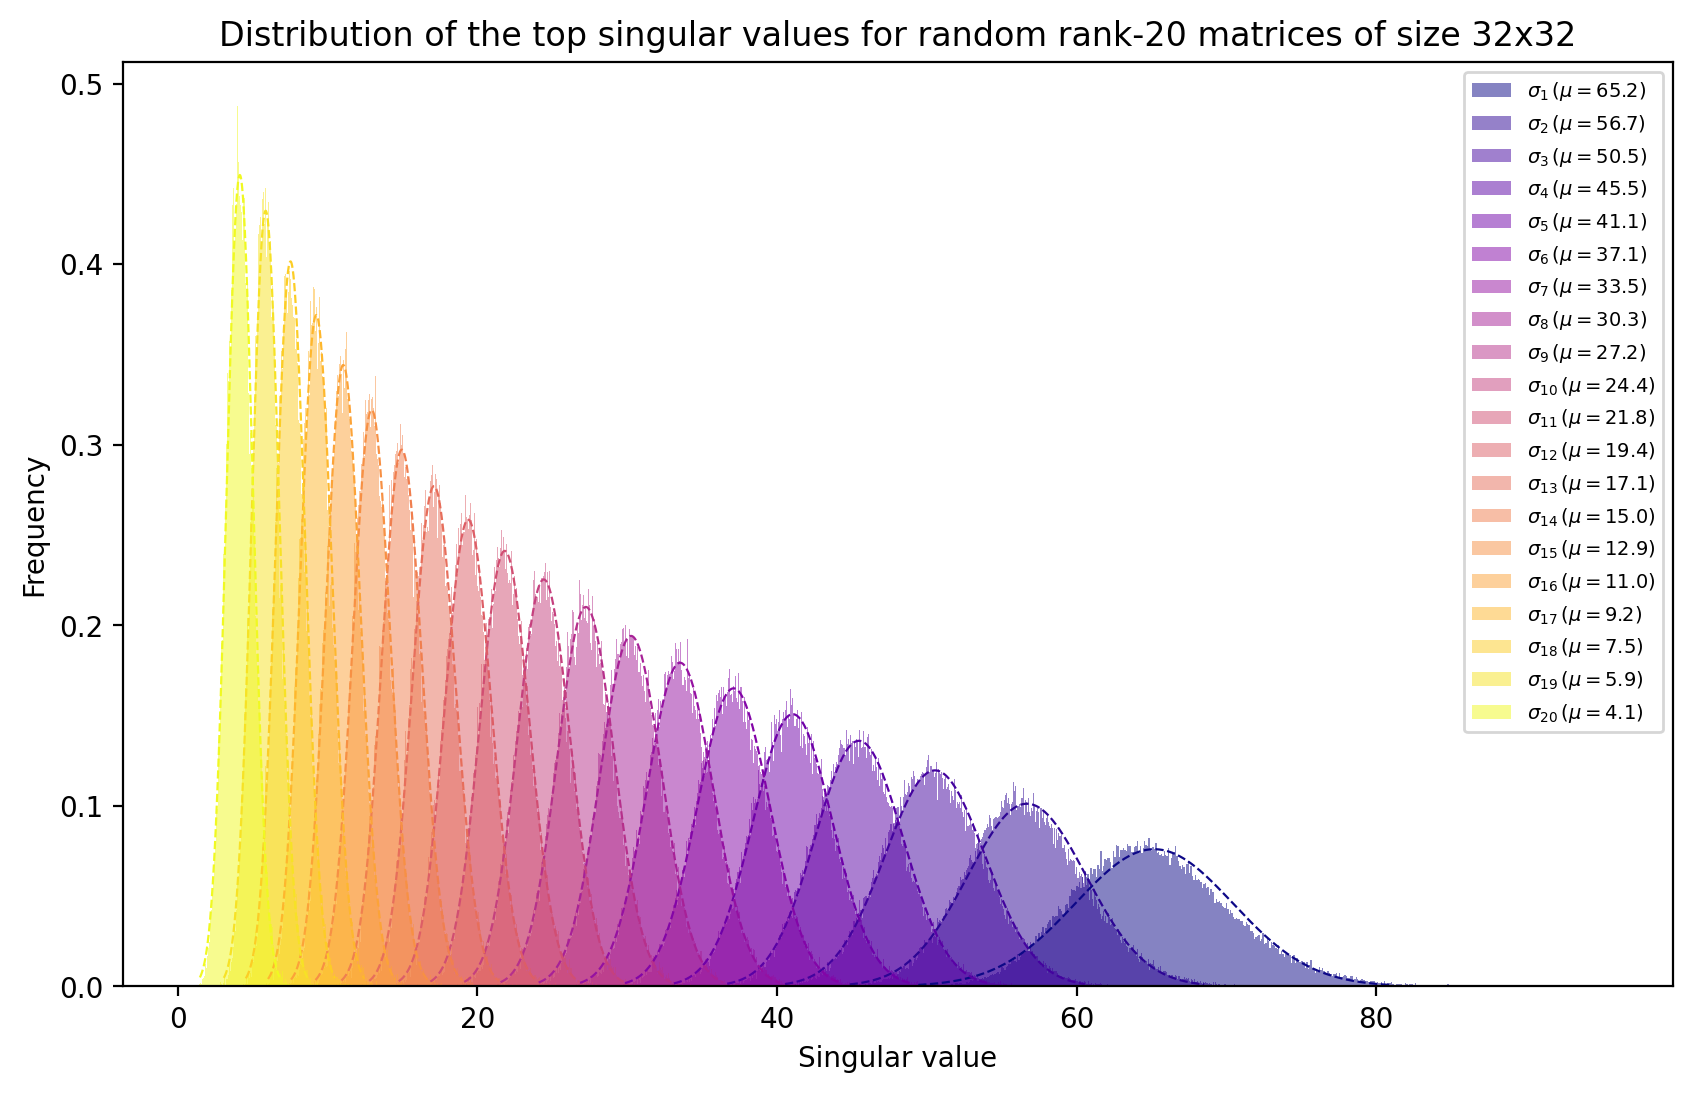

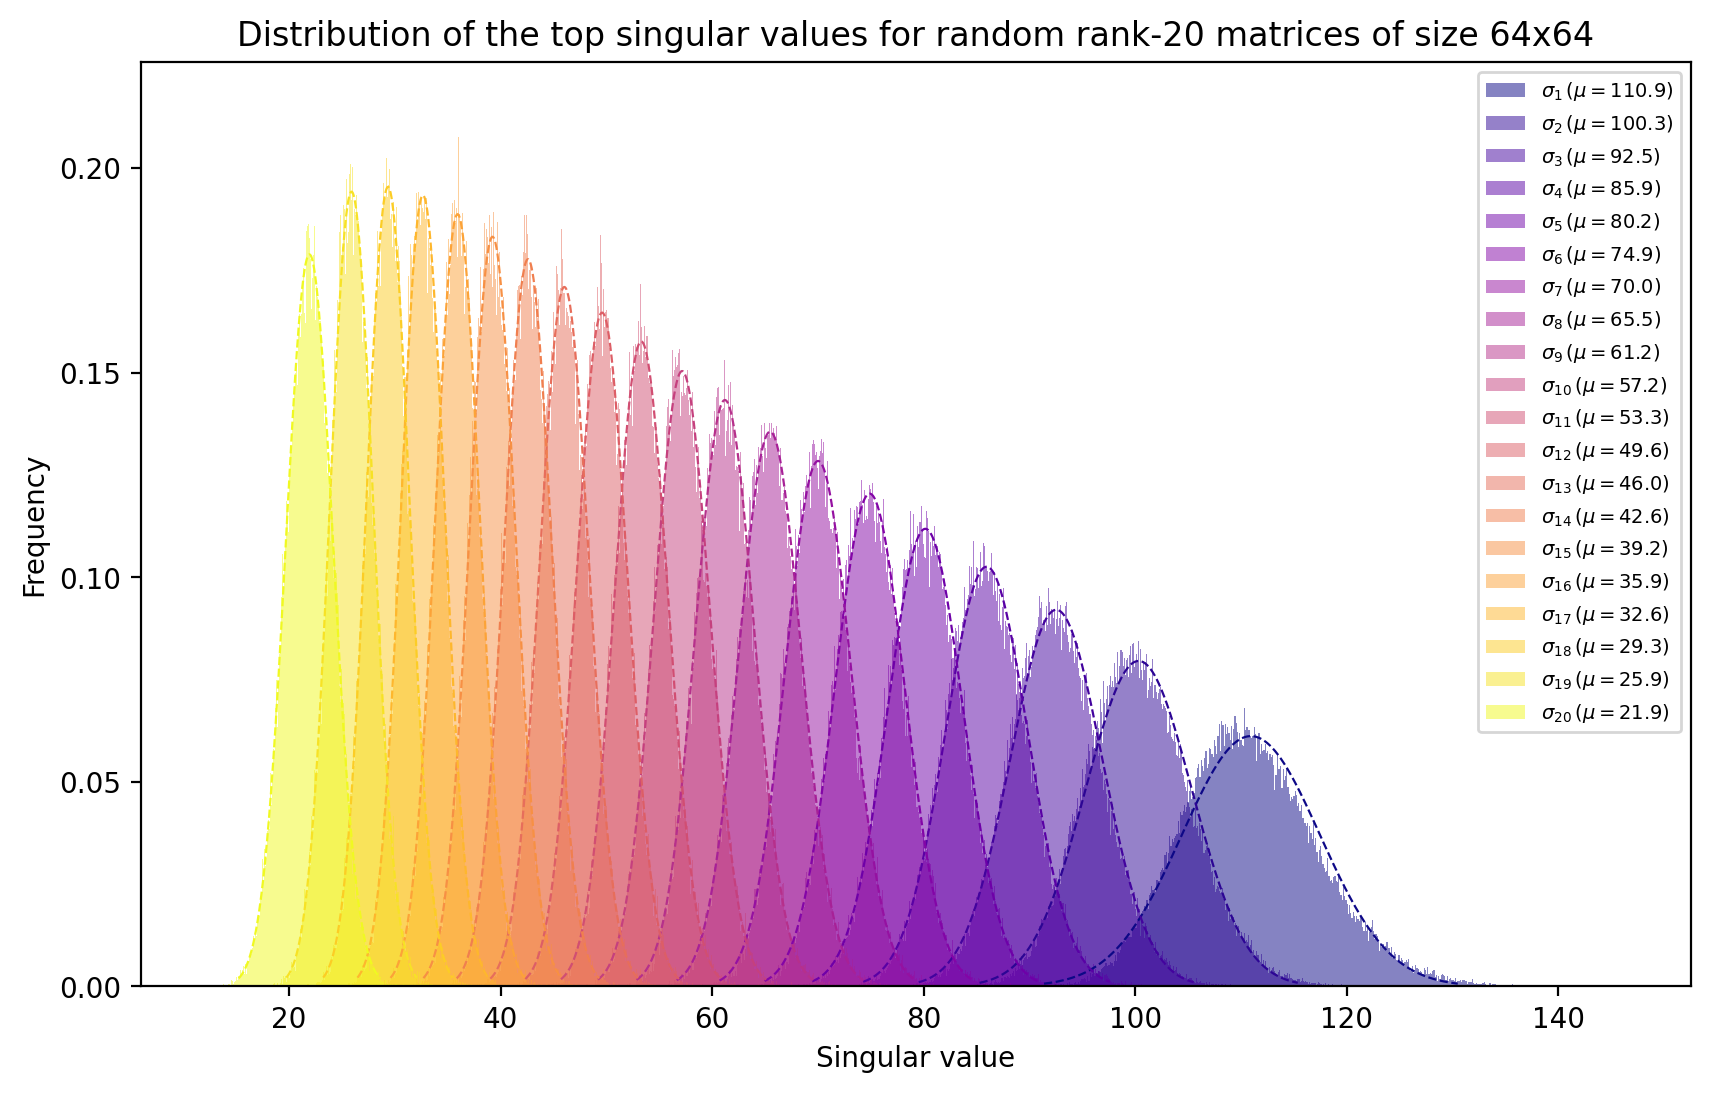

In [330]:
# Plot the histogram of the top k singular values
k = 20

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10, 6))
palette = plt.get_cmap('plasma', k)
for i in range(k):
    mu = np.mean(sv[i])
    nu = np.std(sv[i])
    s1, s2, s3 = f"\sigma_{{{i+1}}} \, (\mu={mu:.1f})", f"\mu={mu:.1f}", f"\nu={nu:.1f}"
    plt.hist(sv[i], bins=500, alpha=0.5, density=True, color=palette(i), label=r"$" + s1 + r"$")
    # Plot a gaussian with the same mean and variance
    x = np.linspace(mu - 3*nu, mu + 3*nu, 1000)
    plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), color=palette(i), linestyle='--', lw=0.8)
plt.legend(fontsize=7)
plt.xlabel("Singular value")
plt.ylabel("Frequency")
plt.title(f"Distribution of the top singular values for random rank-{rank} matrices of size {n}x{n}")
plt.savefig("distrib_singular_values_20_32x32.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10, 6))
palette = plt.get_cmap('plasma', k)
for i in range(k):
    mu = np.mean(sv2[i])
    nu = np.std(sv2[i])
    s1, s2, s3 = f"\sigma_{{{i+1}}} \, (\mu={mu:.1f})", f"\mu={mu:.1f}", f"\nu={nu:.1f}"
    plt.hist(sv2[i], bins=500, alpha=0.5, density=True, color=palette(i), label=r"$" + s1 + r"$")
    # Plot a gaussian with the same mean and variance
    x = np.linspace(mu - 3*nu, mu + 3*nu, 1000)
    plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), color=palette(i), linestyle='--', lw=0.8)
plt.legend(fontsize=7)
plt.xlabel("Singular value")
plt.ylabel("Frequency")
plt.title(f"Distribution of the top singular values for random rank-{rank2} matrices of size {n2}x{n2}")
plt.savefig("distrib_singular_values_20_64x64.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()


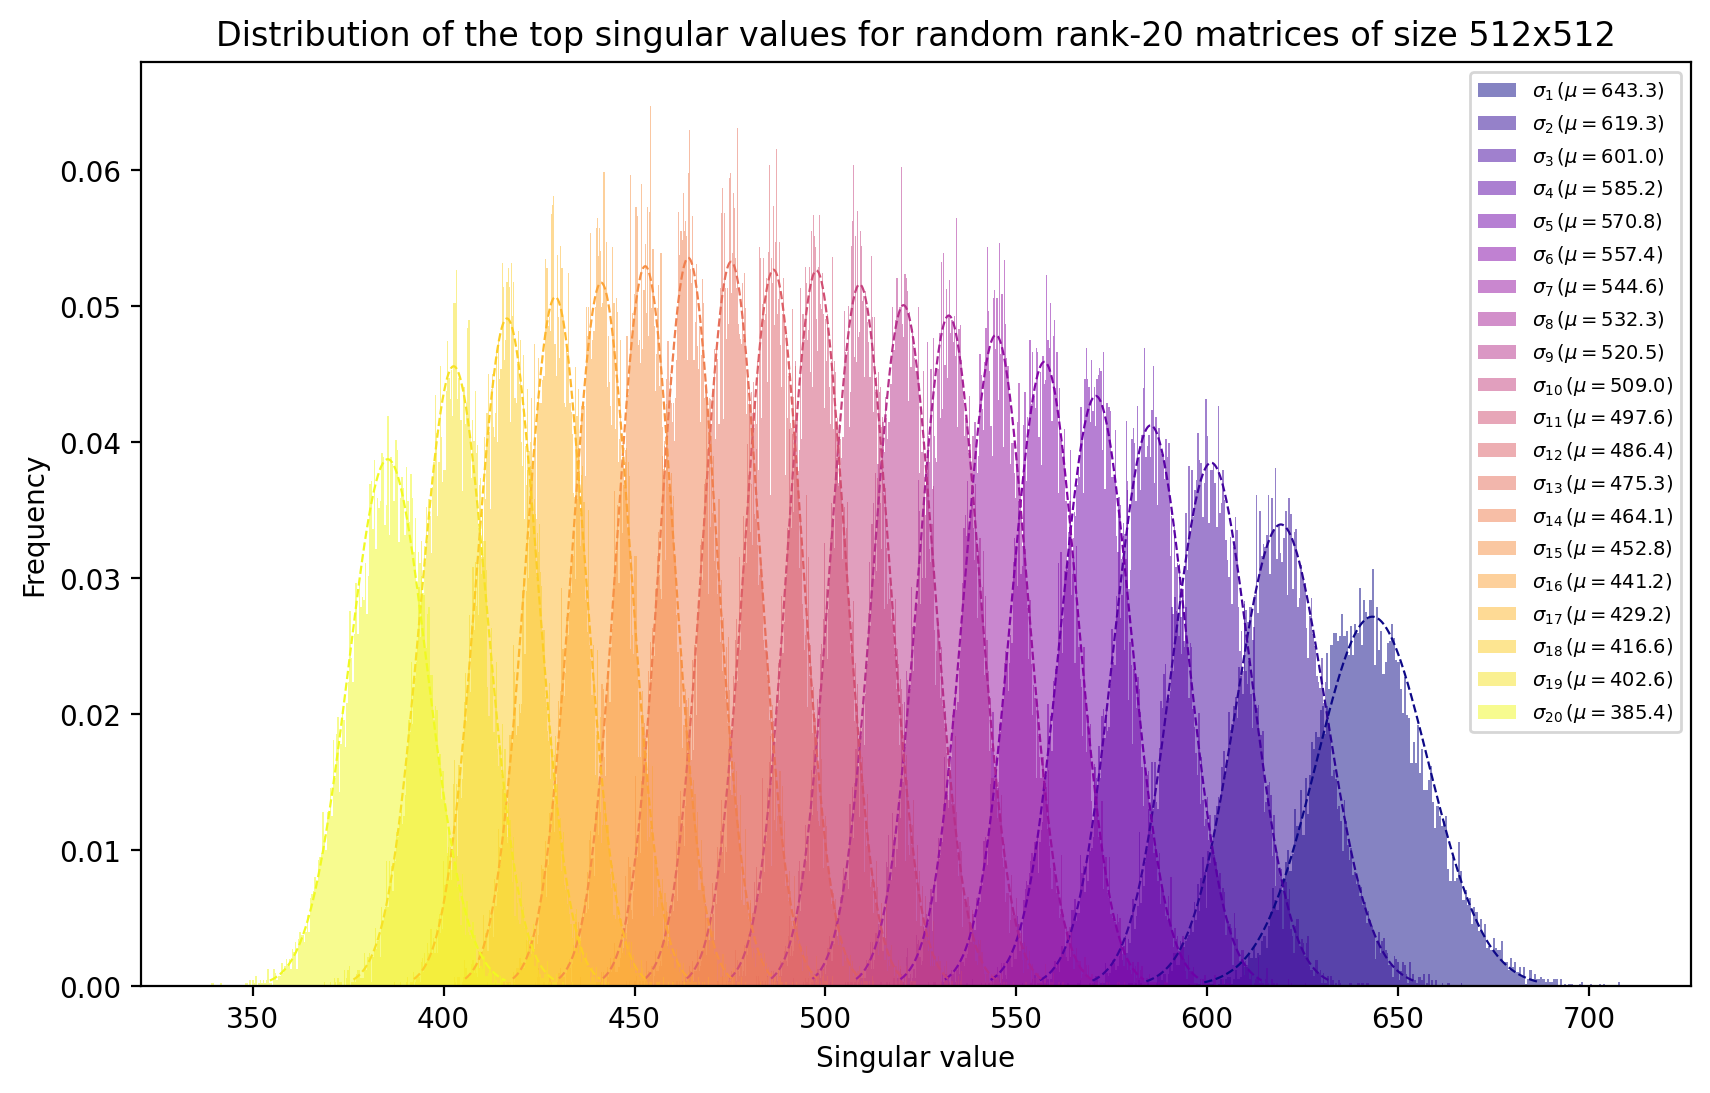

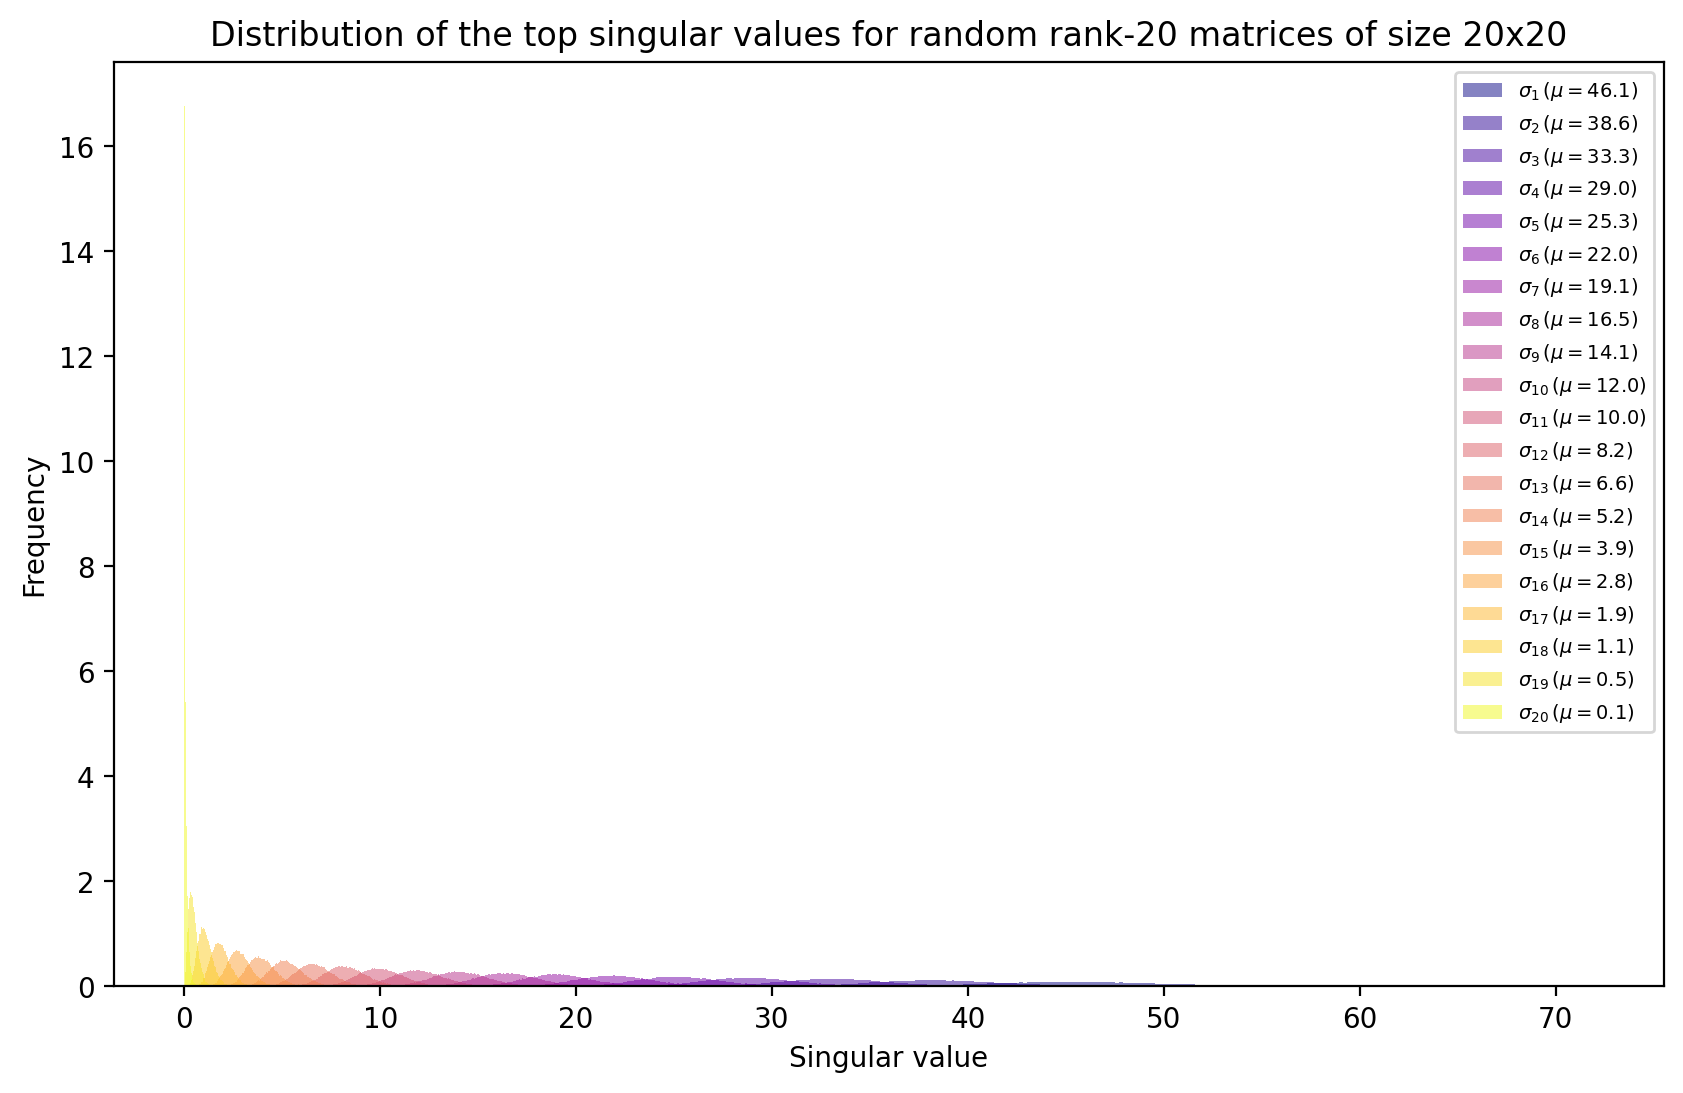

In [15]:
k = 20

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10, 6))
palette = plt.get_cmap('plasma', k)
for i in range(k):
    mu = np.mean(sv4[i])
    nu = np.std(sv4[i])
    s1, s2, s3 = f"\sigma_{{{i+1}}} \, (\mu={mu:.1f})", f"\mu={mu:.1f}", f"\nu={nu:.1f}"
    plt.hist(sv4[i], bins=200, alpha=0.5, density=True, color=palette(i), label=r"$" + s1 + r"$")
    # Plot a gaussian with the same mean and variance
    x = np.linspace(mu - 3*nu, mu + 3*nu, 1000)
    plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), color=palette(i), linestyle='--', lw=0.8)
plt.legend(fontsize=7)
plt.xlabel("Singular value")
plt.ylabel("Frequency")
plt.title(f"Distribution of the top singular values for random rank-{rank4} matrices of size {n4}x{n4}")
plt.savefig("distrib_singular_values_20_512x512.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()

plt.rcParams["figure.dpi"] = 200
plt.figure(figsize=(10, 6))
palette = plt.get_cmap('plasma', k)
for i in range(k):
    mu = np.mean(sv5[i])
    nu = np.std(sv5[i])
    s1, s2, s3 = f"\sigma_{{{i+1}}} \, (\mu={mu:.1f})", f"\mu={mu:.1f}", f"\nu={nu:.1f}"
    plt.hist(sv5[i][1:], bins=200, alpha=0.5, density=True, color=palette(i), label=r"$" + s1 + r"$")
    # Plot a gaussian with the same mean and variance
    # x = np.linspace(mu - 3*nu, mu + 3*nu, 1000)
    # plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), color=palette(i), linestyle='--', lw=0.8)
plt.legend(fontsize=7)
plt.xlabel("Singular value")
plt.ylabel("Frequency")
plt.title(f"Distribution of the top singular values for random rank-{rank5} matrices of size {n5}x{n5}")
plt.savefig("distrib_singular_values_20_20x20.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()

### Basis change coefficient distribution

In [18]:
n = 64
rank = 20
M = random_rank_r(n, n)
U, S, V = torch.svd(M)

u, v = [], []
c, d = [], []
s2 = []

n_samples = 1000
for _ in range(n_samples):
    W = random_rank_r(n, rank)
    U2, S2, V2 = torch.linalg.svd(W)

    # Compute the change of basis matrix U @ U2.T
    C = U.T @ U2
    D = V.T @ V2

    u += U2.reshape(-1).tolist()
    v += V2.reshape(-1).tolist()
    c += C.reshape(-1).tolist()
    d += D.reshape(-1).tolist()
    s2 += (C @ torch.diag(S2) @ D.T).reshape(-1).tolist()

/tmp/ipykernel_3620666/4005597793.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=7)
/tmp/ipykernel_3620666/4005597793.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=7)


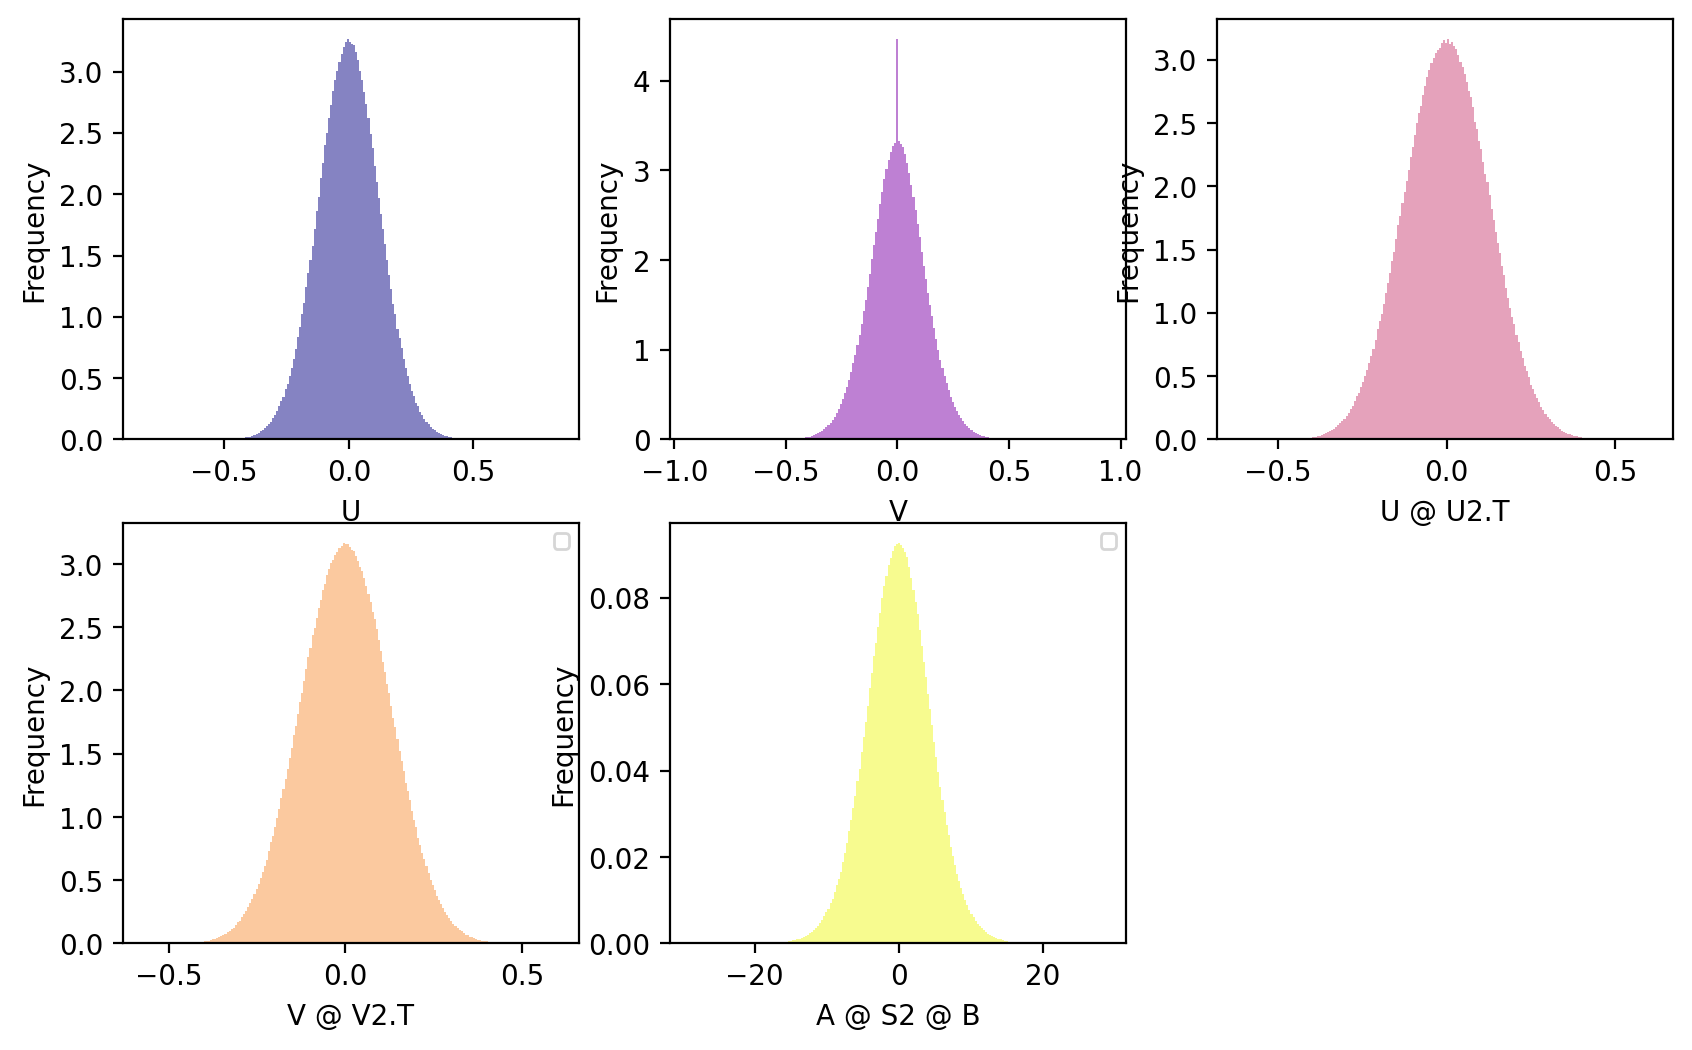

In [19]:
plt.rcParams["figure.dpi"] = 200
palette = plt.get_cmap('plasma', 5)

plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.hist(u, bins=200, alpha=0.5, density=True, color=palette(0))
plt.xlabel("U")
plt.ylabel("Frequency")
plt.subplot(2, 3, 2)
plt.hist(v, bins=200, alpha=0.5, density=True, color=palette(1))
plt.xlabel("V")
plt.ylabel("Frequency")
plt.subplot(2, 3, 3)
plt.hist(c, bins=200, alpha=0.5, density=True, color=palette(2))
plt.xlabel("U @ U2.T")
plt.ylabel("Frequency")
plt.subplot(2, 3, 4)
plt.hist(d, bins=200, alpha=0.5, density=True, color=palette(3))
plt.xlabel("V @ V2.T")
plt.ylabel("Frequency")

plt.subplot(2, 3, 5)
plt.hist(s2, bins=200, alpha=0.5, density=True, color=palette(4))
mu = np.mean(s2)
nu = np.std(s2)
x = np.linspace(mu - 3*nu, mu + 3*nu, 1000)
plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), color='red', linestyle='--', lw=0.8)
plt.xlabel("A @ S2 @ B")
plt.ylabel("Frequency")
# plt.title(f"Distribution of the top singular values for random rank-{rank4} matrices of size {n4}x{n4}")
# plt.savefig("distrib_singular_values_20_512x512.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()

/tmp/ipykernel_3620666/716695000.py:48: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - x**2 - y**2)


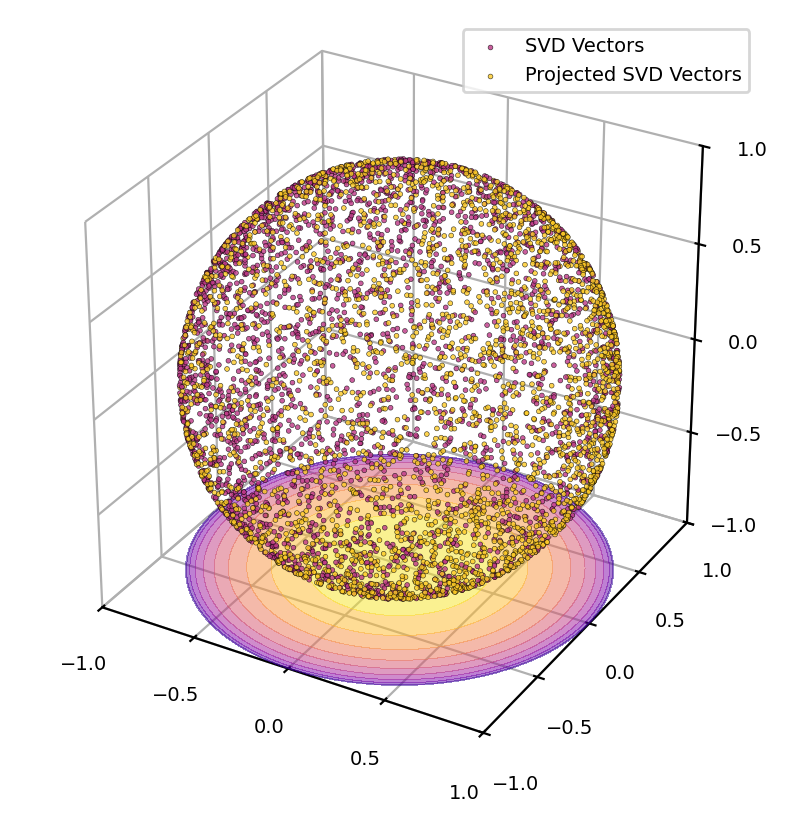

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random vectors
W = np.random.normal(size=(3, 3), loc=0, scale=1)
U, _, V = np.linalg.svd(W, full_matrices=True)

def generate_svd_vectors(dim):
    vectors = np.random.normal(size=(dim, dim), loc=0, scale=1)
    U, _, V = np.linalg.svd(vectors, full_matrices=True)
    return U

def generate_projected_svd_vectors(dim):
    vectors = np.random.normal(size=(dim, dim), loc=0, scale=1)
    U2, _, V2 = np.linalg.svd(vectors, full_matrices=True)
    return U.T @ U2

# Number of vectors and dimension
n_vectors = 1000
dimension = 3

# Generate vectors
singular_vectors = []
projected_singular_vectors = []
for _ in range(n_vectors):
    sv = generate_svd_vectors(dimension)
    psv = generate_projected_svd_vectors(dimension)
    singular_vectors += sv.tolist()
    projected_singular_vectors += psv.tolist()
singular_vectors = torch.tensor(singular_vectors)
projected_singular_vectors = torch.tensor(projected_singular_vectors)

# Plotting
fig = plt.figure()
palette = plt.get_cmap('plasma', 10)

ax = fig.add_subplot(111, projection='3d')

ax.scatter(singular_vectors[:500, 0], singular_vectors[:500, 1], singular_vectors[:500, 2], s=3, alpha=0.8, label='SVD Vectors', color=palette(4), edgecolors='black', linewidths=0.2)
ax.scatter(projected_singular_vectors[:500, 0], projected_singular_vectors[:500, 1], projected_singular_vectors[:500, 2], s=3, alpha=0.8, label='Projected SVD Vectors', color=palette(8), edgecolors='black', linewidths=0.2)
ax.scatter(singular_vectors[500:, 0], singular_vectors[500:, 1], singular_vectors[500:, 2], s=3, alpha=0.8, color=palette(4), edgecolors='black', linewidths=0.2)
ax.scatter(projected_singular_vectors[500:, 0], projected_singular_vectors[500:, 1], projected_singular_vectors[500:, 2], s=3, alpha=0.8, color=palette(8), edgecolors='black', linewidths=0.2)

x = np.linspace(-1, 1, 10000)
y = np.linspace(-1, 1, 10000)
x, y = np.meshgrid(x, y)
z = np.sqrt(1 - x**2 - y**2)
ax.contourf(x, y, z, zdir='z', offset=-1, cmap='plasma', alpha=0.5, levels=10)

# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
# Set ticks only for -1, 0, 1
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
# Adjust the padding of the axis
# ax.xaxis.labelpad = 10
# ax.yaxis.labelpad = 10
# ax.zaxis.labelpad = 10

# Remove distortion
ax.set_box_aspect([1,1,1])
# Set background color to transparent
ax.patch.set_alpha(0)
# Remove background color
ax.patch.set_facecolor('none')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Set ticks font size
ax.tick_params(axis='both', which='major', labelsize=7)
ax.legend(fontsize=7)
# plt.title('Distribution of Singular Vectors')
plt.savefig("distribution_singular_vectors.png", dpi=200, transparent=True, bbox_inches='tight')
plt.show()


In [223]:
from sympy import *
from sympy import symbols, Function, integrate, diff
from scipy.special import airy
from scipy.integrate import solve_ivp, quad

t, x = symbols("t x")
q = Function("q")
I = integrate((x-t)*q(x)**2, (x, t, oo))
I_prime = diff(integrate((x-t)*q(x)**2, (x, t, oo)), t)
I_prime2 = diff(integrate((x-t)*q(x)**2, (x, t, oo)), t, 2)
J = integrate(q(x), (x, t, oo))

def f(t, y):
    d0 = y[1]
    d1 = t*y[0]+2*y[0]**3
    d2 = y[3]
    d3 = y[0]**2
    d4 = -y[0]
    return np.array([d0, d1, d2, d3, d4])

t0 = +10
tf = -10

y0_0 = airy(t0)[0]
y0_1 = airy(t0)[1]
y0_2 = quad(lambda x: (x-t0)*airy(x)[0]**2, t0, np.inf)[0]
y0_3 = airy(t0)[0]
y0_4 = quad(lambda x: airy(x)[0], t0, np.inf)[0]
y0 = np.array([y0_0, y0_1, y0_2, y0_3, y0_4])

sol = solve_ivp(f, (t0, tf) ,y0, max_step=.1)

F2 = np.exp(-sol.y[2])
f2 = -sol.y[3] * F2

F1 = np.sqrt(F2 * np.exp(-sol.y[4]))
f1 = 1/(2*F1)*(f2+sol.y[0]*F2)*np.exp(-sol.y[4])

# plt.plot(sol.t, f2, label="β=2")
# plt.plot(sol.t, f1, label="β=1")
# plt.xlabel("t")
# plt.ylabel("density")
# plt.title("Tracy Widom for β=1,2")
# plt.legend();


16.29387049630165 4


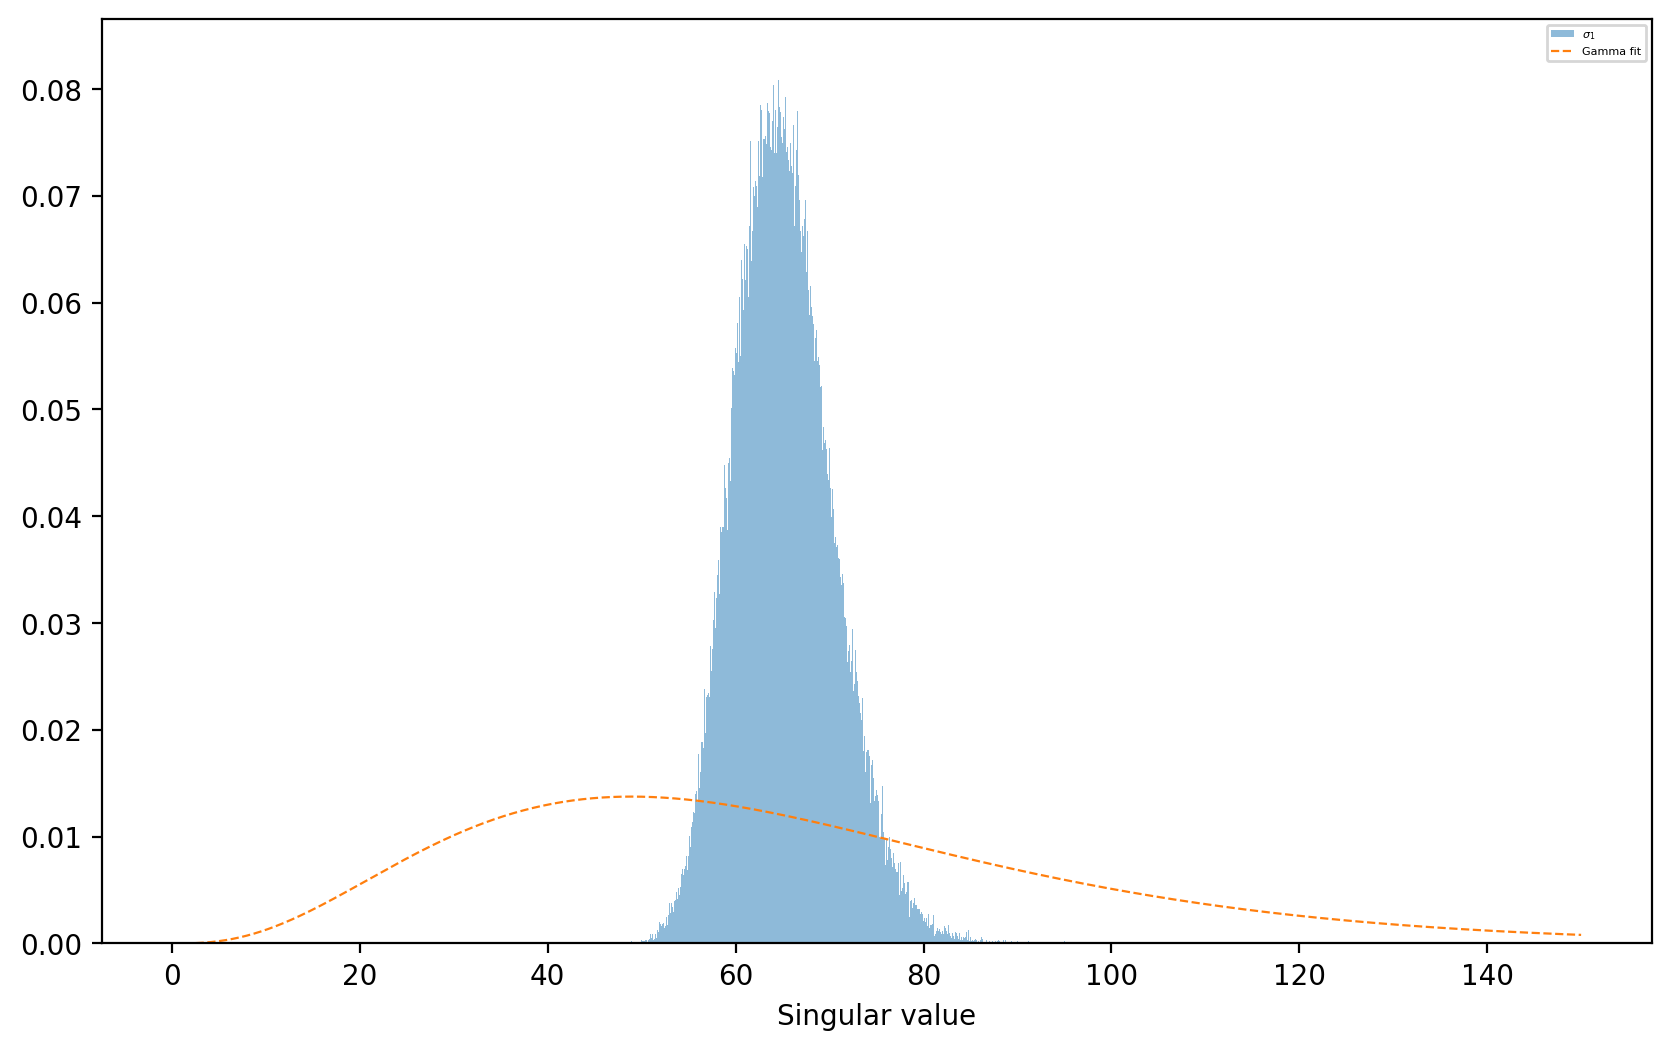

In [251]:
from scipy.special import kv
# import gamma function
from scipy.special import gamma

plt.figure(figsize=(10, 6))

mu, nu = np.mean(sv[0]), np.std(sv[0])
plt.hist(sv[0], bins=500, alpha=0.5, density=True, label=r"$\sigma_1$")
# plt.plot(sol.t+mu, f1, label="β=1")
# plt.plot(sol.t+mu, f2, label="β=1")

# Plot gaussian
# x = np.linspace(mu - 20*nu, mu + 20*nu, 1000)
x = np.linspace(0, 150, 1000)

k = 4
theta = mu/k#nu**2 / mu
print(theta, k)
plt.plot(x, 1/(gamma(k) * theta**k) * x**(k-1) * np.exp(-x/theta), linestyle='--', lw=0.8, label="Gamma fit")
# plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), linestyle='--', lw=0.8, label="Gaussian fit")
# Plot variance-gamma distribution
# plt.plot(x, 2 * x * np.exp(-x**2), linestyle='--', lw=0.8, label="Variance-Gamma")
# plt.plot(x, kv(0, np.abs(x-mu)) / (nu * np.pi) * np.exp((x-mu)/nu**2), linestyle='--', lw=0.8, label="Variance-Gamma")

def vg_density(x, r, theta, sigma, mu):
    a = np.sqrt(theta**2+sigma**2)
    C = 1/(sigma * np.sqrt(np.pi) * gamma(r/2))
    e = np.exp(theta * (x-mu) / sigma**2)
    return C * e * (np.abs(x-mu)/(2 * a))**((r-1)/2) * kv((r-1)/2, np.abs(x-mu) * a / sigma**2)


# beta = 1
# plt.plot(x, np.where(x > rank/2, np.exp(-2 * beta / 3 * np.abs(x) ** (3/2)), np.exp(- beta / 24 * np.abs(x) ** (3))))


# plt.plot(x, kv(0, np.abs(x-mu)) / (nu * np.pi) * np.exp((x-mu)/nu**2), linestyle='--', lw=0.8, label="Variance-Gamma")

# r = [4]
# theta = [0, 0.5, 1, 2]
# sigma = [nu]
# # mus = [mu-2]

# from itertools import product

# plt.plot(x, 1/(nu * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * nu**2)), linestyle='--', lw=0.8, label="Gaussian fit")

# for r_, theta_, sigma_ in product(r, theta, sigma):
#     sigma_ = np.sqrt(nu**2/2 - theta_**2)
#     mu_ = mu - theta_
#     plt.plot(x, vg_density(x, r_, theta_, sigma_, mu_), lw=0.6, label=f"VG r={r_:.1f}, theta={theta_:.1f}, sigma={sigma_:.1f}, mu={mu_:.1f}")

plt.xlabel("Singular value")
plt.legend(fontsize=4)
plt.show()